In [3]:
from __future__ import print_function   # Python 2/3 compatability

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import shapely.geometry
import shapely.ops

In [15]:
from mpl_toolkits.basemap import Basemap
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)

array(['Arizona', 'California', 'Colorado', 'Connecticut', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Missouri', 'Nebraska', 'Nevada',
       'New Jersey', 'New Mexico', 'New York', 'Ohio', 'Pennsylvania',
       'Utah', 'West Virginia'], 
      dtype='<U13')

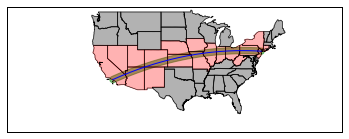

In [7]:
m.readshapefile('./states_21basic/states', 'states')
x,y = m.gcpoints(-118.4081, 33.9425,-74.1686,40.6925,1000)
polys = []
for state in m.states:
    polys.append(shapely.geometry.Polygon(state))

points = []
for i in range(len(x)):
    points.append(shapely.geometry.Point(x[i], y[i]))

line = shapely.geometry.LineString(points)
line_buf = line.buffer(100000)
#intersections = [poly.intersects(line_buf) for poly in polys]
plt.plot(*line.xy)
plt.fill(*line_buf.boundary.xy, color='g', alpha=0.5)
state_name = []
for i,poly in enumerate(polys):
    if poly.intersects(line_buf):
        color = 'r'
        state_name.append(m.states_info[i]['STATE_NAME'])
    else:
        color = 'k'
    coords = poly.exterior.coords
    x1, y1 = zip(*coords)
    plt.fill(x1, y1, color=color, alpha=0.3)
np.unique(state_name) #List of states name that can be seen.

Q1 Flyover states

2.02778244267
0.9997882598652641
0.8772730448315533
0.09372659526518255


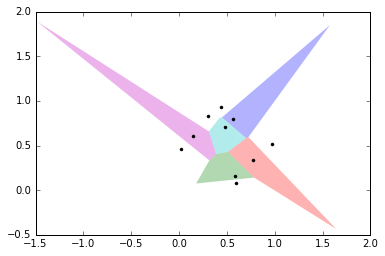

In [8]:
from scipy import spatial
import numpy as np
pts=np.array([[ 0.77354201,  0.34072038],
           [ 0.43807549,  0.93001924],
           [ 0.5624092 ,  0.79438991],
           [ 0.02536295,  0.46180244],
           [ 0.59533179,  0.07522803],
           [ 0.47867418,  0.70302822],
           [ 0.30371564,  0.83135442],
           [ 0.5856915 ,  0.16340903],
           [ 0.14700491,  0.60268997],
           [ 0.97098631,  0.51692456]])

vor = spatial.Voronoi(pts)

def poly_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1)) - np.dot(y,np.roll(x,1)))

total_area = 0.
total2_area = 0.
total3_area = 0.
total4_area = 0.
import shapely.geometry
import shapely.ops
for indices in vor.regions:
    if not indices: continue     # check for empty regions
    if -1 in indices: continue   # region includes a vertex out of the diagram (the region goes to infinity)
    total_area += poly_area(vor.vertices[indices, 0],vor.vertices[indices, 1]) 
    xy = zip(vor.vertices[indices, 0], vor.vertices[indices, 1])
    poly = shapely.geometry.Polygon(xy)
    total_area += poly.area
    poly2 = poly.buffer(-0.001)
    total2_area += poly2.area
    poly3 = poly.buffer(-0.01)
    total3_area += poly3.area
    poly4 = poly.buffer(-0.1)
    total4_area += poly4.area
    plt.fill(vor.vertices[indices, 0], vor.vertices[indices, 1], edgecolor='none', alpha=0.3)

plt.plot(pts[:, 0], pts[:, 1], '.k')

print(total_area)     #original area
print(total2_area)    #area shrink 0.001
print(total3_area)    #area shrink 0.01
print(total4_area)    #area shrink 0.1


Q2 Area in a Voronoi diagram

In [11]:
from scipy import interpolate

f = open('./data/MS03_L15.txt','r')
f.seek(0)

lat = []
dep = []
temperature = []
for line in f.readlines():
    data = line.split(' ')
    if data[0] == '':
        i = 0
        for str_data in data:
            if str_data != '':
                i += 1
                if i == 1:
                    lat.append(float(str_data))
                elif i == 3:
                    dep.append(float(str_data))
                elif i == 4:
                    temperature.append(float(str_data))

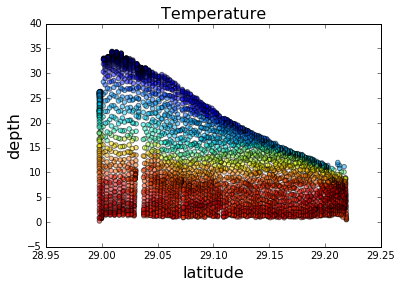

In [12]:
from scipy import interpolate

colors = temperature
plt.scatter(lat[::10], dep[::10], c=colors[::10], alpha=0.5)
plt.xlabel('latitude', fontsize=16)
plt.ylabel('depth', fontsize=16)
plt.title('Temperature', fontsize=16)

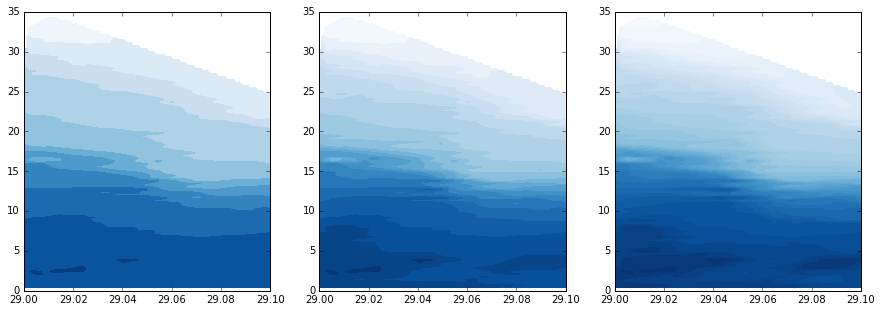

In [13]:
pts = [[lat[i],dep[i]] for i in range(len(dep))]
tri = spatial.Delaunay(pts)
interp = interpolate.LinearNDInterpolator(tri, temperature)


ygrid, xgrid = np.meshgrid(np.mgrid[0:35:100j], np.mgrid[29:29.1:100j])
zgrid = interp(xgrid, ygrid)
zgrid = np.ma.masked_where(np.isnan(zgrid), zgrid)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].contourf(xgrid, ygrid, zgrid, 10, cmap='Blues')
axs[1].contourf(xgrid, ygrid, zgrid, 20, cmap='Blues')
axs[2].contourf(xgrid, ygrid, zgrid, 40, cmap='Blues')

Q3 2D interpolation

In [16]:
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
m.readshapefile('./data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False) 
m.readshapefile('./data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
greenland_area = 0.
australia_area = 0.
for pgl in m.greenland:
    greenland_area += shapely.geometry.Polygon(pgl).area
for paus in m.australia:
    australia_area += shapely.geometry.Polygon(paus).area
print(greenland_area/australia_area) #Mercator much larger than the real 0.2815824915824916

3.639769417702679


In [17]:
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='robin',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
m.readshapefile('./data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False) 
m.readshapefile('./data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
greenland_area = 0.
australia_area = 0.
for pgl in m.greenland:
    greenland_area += shapely.geometry.Polygon(pgl).area
for paus in m.australia:
    australia_area += shapely.geometry.Polygon(paus).area
print(greenland_area/australia_area) #Robinson still larger than the real ratio 0.2815824915824916

0.5040096152236905


In [78]:
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='moll',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
m.readshapefile('./data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False) 
m.readshapefile('./data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)
greenland_area = 0.
australia_area = 0.
for pgl in m.greenland:
    greenland_area += shapely.geometry.Polygon(pgl).area
for paus in m.australia:
    australia_area += shapely.geometry.Polygon(paus).area
print(greenland_area/australia_area) #Mollweide smaller than the real ratio 0.281582491582491

0.2772141804361564


Q4 (Grad) Area of Greenland and Australia in different projections